### ** PROJECT 1: Automaitc Land Finding**
***

My first Jupyter Notebook. Hopefully it would go well

#### Goal:
    1. Apply Canny Transformation, Hough Transformation to extract lane lines in a given frame (or image)
    2. Familiar myself with OpenCV and numpy operation.
    3. Believe that I can be a self-driving engineer :D [ I used to attempt to work on self-driving car projects many times but I always failed because I did not have a mentor nor lacked of knowledge.


In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import stats

# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

** My PipeLine/Algorithm **

Global Variables:

* previous_left_right_slopes = []

* previous_polygon_vertices  = []


For every frame in a video:
    * Filtering image using HSV color space
    1. Apply Canny Edge and Hough Transform         
    3. Mask Region of Intrest         
    3. For each line segments:
        a. Calculate the slope
            if (slope > 0): 
                add to right_slopes
                compare to Max_point (highest ponint) and Min_point (lowest_point).
            if (slope < 0): 
                add to left_slopes
                compare to Max_point and Min_point.
    4. Calcualte Median left and right slopes relatively to previous slope
    5. Extrapolate max points using median slope and bottom points
        

### ** Here are some of helper functions for the main pipeline**


In [3]:
def draw_lanes(source_img, lines, color=[255, 0, 0], thickness=2):
    """ 
    Draw left and right lines to the image
    
    :param source_img : a source image
    :param lines      : a list of lines
    :param color      : color of the line
    :param thickness  : thickness of the line
    
    :return: an image with lines on it
    """
    
    img = np.copy(source_img)
    

    return img


def draw_line_segments(source_image, h_lines, color=[255, 0, 0], thickness=2):
    """
    Draw the line segments to the source images.
    """

    line_img = np.copy(source_image)

    for a_line in h_lines:
        for x1, y1, x2, y2 in a_line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img


In [4]:
def edge_detector(gray_img, gaussian_kernel_size=1, low_threshold=0, high_threshold=10):
    """
    Return possible edges in an image using Canny Transformation
    :param gray_img:             a grayed image
    :param gaussian_kernel_size: a kernel size for gaussian blur [default is 0]
    :param low_threshold:        default is 0
    :param high_threshold:       default is 10
    :return: edges in an image
    """
    
    # Apply gaussian blur  
    kernel_size = (gaussian_kernel_size, gaussian_kernel_size)
    blurred_image = cv2.GaussianBlur(gray_img, kernel_size, 0)

    # Canny Edge Detection
    canny_edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
    return canny_edges


def find_hough_lines(edge_img, min_votes, min_length, max_gap):
    """
    Return a list of possible Hough Lines in edge_img
    
    :param edge_img:    a canny edge image
    :param min_votes:   a minimum threshold [votes] to be considered a possible line
    :param min_length:  a minimum length to be considered a line
    :param max_gap:     maximum gap between points that have the same line
    :return:            a list of possible lines
    
    Notice : a line in openCV contains : 2 vertices (x1,y1) and (x2,y2)
    """
    
    rho = 1             # perpendicular distance from origin to a line
    theta = np.pi/180   # angle between line and x-axis
    
    # Hough Transform Built-in function of OpenCV. Return a line segments in image
    lines = cv2.HoughLinesP(edge_img, rho, theta, min_votes, np.array([]), min_length, max_gap)

    return lines



def region_of_interest(img, vertices):
    """
    Filter out not-so-important region in the image
    :param source_img:
    :param vertices:    list of vertices to create a polygon
    :return:
    """
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    
     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges


def adaptive_equalize_image(img, level):
    """
    Equalize an image - Increase contrast for the image
        # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        
    :param img:    an gray image
    :param level:  clipLevel
    :return: a equalized image
    """
    clahe = cv2.createCLAHE(clipLimit=level)
    result = clahe.apply(img)
    return result

### ** Helper functions **

In [26]:
def gray_image(img):
    """
    Convert color image into gray scale image
    :param img: a color image
    :return: a gray image
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hsv_image(img):
    """
    Convert BGR to HSV
    green = np.uint8([[[255,236,107]]])
    hsv_green = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
    print(hsv_green)
    """
    # Conver BGR to LAB
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = adaptive_equalize_image(l, 3.0)
    merge = cv2.merge((cl, a, b))
    equalized = cv2.cvtColor(merge, cv2.COLOR_LAB2BGR)
    # Convert to HSV image
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    WHITE_MIN = np.array((30,5, 160))
    WHITE_MAX = np.array((130,20,255))

    YELLOW_MIN = np.array((89 ,40, 160))
    YELLOW_MAX= np.array((100, 200, 255))

    white_mask = cv2.inRange(hsv,WHITE_MIN, WHITE_MAX)
    yellow_mask = cv2.inRange(hsv, YELLOW_MIN, YELLOW_MAX)
#     plt.figure(2)
#     plt.imshow(white_mask, cmap='gray')
#     plt.figure(1)
#     plt.imshow(yellow_mask, cmap='gray')
    mask = cv2.addWeighted(white_mask,1.0,yellow_mask,1.0,0.0)
    result = cv2.bitwise_and(image, image, mask= mask)
    return result
    

def calculate_slope(line):
    """
    Calculate a slope of a line segment
    :param line:
    :return: slope value
    """
    slope = 0
    for x1, y1, x2, y2 in line:
        slope = (y1 - y2)/(x1 - x2)
    return slope


def update_boundary(line_segment, curr_max, curr_min):
    """
    Update max point and min point of the line
    """
    for x1, y1, x2, y2 in line_segment:
        if  y1 < curr_max[1]:
            curr_max = [x1, y1]
            
        elif y1 > curr_min[1]:
            curr_min = [x1, y1]
            
        if  y2 < curr_max[1]:
            curr_max = [x2, y2]
            
        elif y2 > curr_min[1]:
            curr_min = [x2, y2]
    
    return [curr_max, curr_min]

    
    return (max_point, min_point)


def get_line(slope, points, upper_y, yaxis, btm_point, prev_int, alpha):
    """
    """
    if len(points) > 0:
         # Find y-intercept
        intercept = btm_point[1] - slope*btm_point[0]
        intercept = alpha*intercept + (1-alpha)*prev_int
        # Calculate upper_x
        upper_x = (upper_y - intercept)/slope

        # Calculate X_min
        lower_x = yaxis - intercept
        lower_x = lower_x/slope
        
        upper_x = int(upper_x)
        lower_x = int(lower_x)
        
        if math.isinf(upper_y):
            upper_y = int(yaxis*0.5)
    
        line = np.array([[upper_x, int(upper_y), lower_x, int(yaxis)]])
        return line, intercept
    else:
        return np.array([[0,0,0,0]]), prev_int
    
    
def cal_slope_weight(line):
    for x1,y1, x2, y2 in line:
        distance = math.pow(((x1-x2)**2 + (y1-y2)**2),2)
    return distance   

def avg_slope(slopes):
    """
    calculate avg slope based on the length of the edge (weight). 
    The longer edge, the more it affects the avg slope
    """
    slope = np.transpose(slopes)[0]
    weight = np.transpose(slopes)[1]
    
    mul_sw = np.sum(np.multiply(slope,weight))
    sum_w  = np.sum(weight)
    
    avg_slope = mul_sw/sum_w
    
    return avg_slope

def smooth_slope(new, prev, alpha):
    return alpha*new +(1-alpha)*prev
    
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



This image is: <class 'numpy.ndarray'> with dimensions: (1047, 1854, 3)


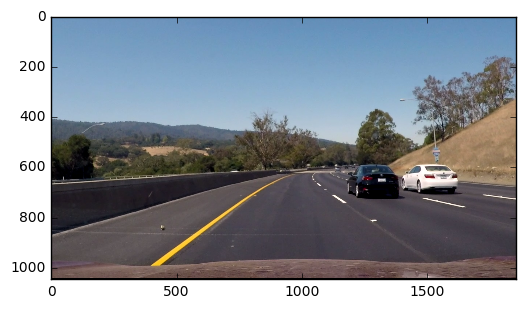

In [27]:
#image = mpimg.imread('./test_images/whiteCarLaneSwitch.jpg')
image = (mpimg.imread('challenge2.png')*255).astype('uint8')
plt.imshow(image)
print('This image is:', type(image), 'with dimensions:', image.shape)

### ** Initialize polygon vertices and slopes **

In [28]:
im_shape = image.shape
xsize = im_shape[0]
ysize = im_shape[1]

# Points of polygon
left_top = (ysize * 0.46, xsize * 0.55)
left_bottom = (0+ysize*0.12, xsize)

right_top = (ysize * 0.52, xsize * 0.55)
right_bottom = (ysize - ysize*0.07, xsize)
vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

# Initial points
upper_left = [ysize, xsize]
lower_left = [0, 0]

upper_right = [ysize * 0.52, xsize * 0.5]
lower_right = [0, xsize * 0.5]

right_points = []
left_points = []

#Initial slopes
right_slopes = []
left_slopes = []

# print(xsize, ysize)


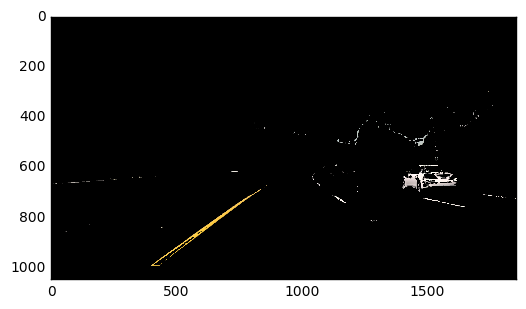

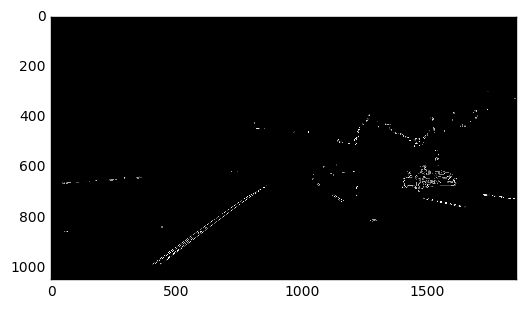

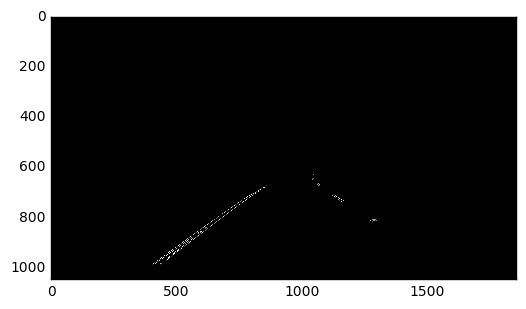

In [29]:
# HSV improvement
hsv = hsv_image(image)
plt.imshow(hsv)
# Apply Canny Edge Detection
canny = edge_detector(hsv, 7, 120, 150)
plt.figure(2)
plt.imshow(canny, cmap='gray')
# Mask a Region Of Interest 
edges = region_of_interest(canny, vertices)

color_edges = np.dstack((edges, edges, edges)) 

# Hough Transform
h_lines = find_hough_lines(edges, 9, 120, 120)
plt.figure(3)
plt.imshow(edges, cmap='gray')

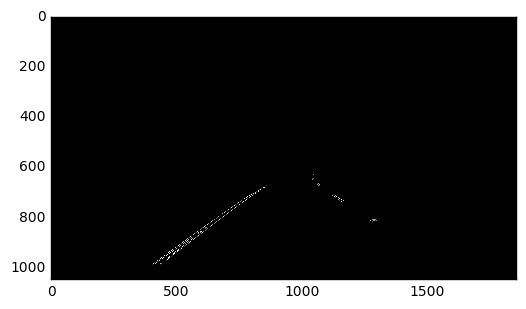

In [30]:
color_edges = np.dstack((edges, edges, edges)) 
plt.imshow(color_edges)

In [31]:
for line in h_lines:
    slope = calculate_slope(line)
    if slope > 0:
        w = cal_slope_weight(line)
        right_slopes.append([slope, w])
        for x1, y1, x2,y2 in line:
            right_points.append((x1, y1))
            right_points.append((x2, y2))
        [upper_right,lower_right] = update_boundary(line, upper_right,lower_right)
    if slope < 0:
        w = cal_slope_weight(line)
        left_slopes.append([slope, w])
        for x1, y1, x2,y2 in line:
            left_points.append((x1, y1))
            left_points.append((x2, y2))
        [upper_left, lower_left] = update_boundary(line, upper_left, lower_left)

print(upper_left, lower_left)
print(upper_left, lower_left)

[830, 690] [422, 995]
[830, 690] [422, 995]


In [32]:
# Calculate Lines
right_slope = avg_slope(right_slopes)
left_slope = avg_slope(left_slopes)

# right_slope = np.median(np.transpose(right_slopes)[0])
# left_slope = np.median(np.transpose(left_slopes)[0])
print(right_slope, left_slope)



0.648913522151 -0.754320749239


0.0 0.0
[[ -914   690 -1388  1047]] [[1063  690 1613 1047]]


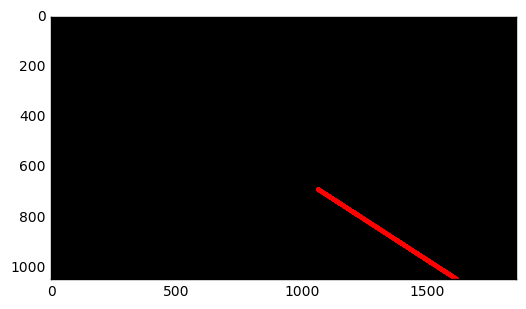

In [33]:
# To avoid float infinity 
upper_y = np.maximum(upper_left[1],upper_right[1])
temp = 0
temp1 =0
left_line, temp   = get_line(left_slope,  left_points, upper_y, xsize, lower_left, 0,1 )
right_line, temp1 = get_line(right_slope, right_points, upper_y, xsize, lower_right,0,1 )
print(temp, temp1)
line_image = draw_line_segments(np.copy(image)*0, [left_line], [255, 0, 255], 20)
line_image = draw_line_segments(line_image,  [right_line], [255, 0, 0], 20)

plt.imshow(line_image)
line_image = region_of_interest(line_image,vertices)
result = weighted_img(image, line_image)
print(left_line, right_line)


Original Image: 
Canny Edge and Hough Transform:
Result:


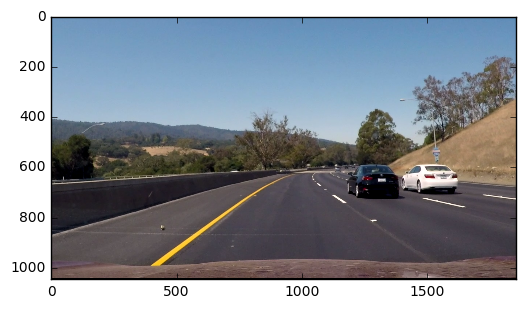

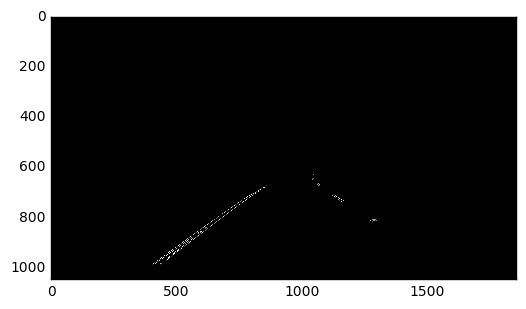

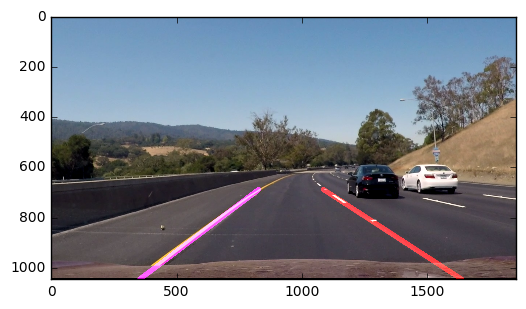

In [21]:
# Display all line

plt.figure(1)
print("Original Image: ")
plt.imshow(image)

plt.figure(2)
print("Canny Edge and Hough Transform:")
plt.imshow(edges, cmap='gray')

plt.figure(3)
print("Result:")
plt.imshow(result)

In [24]:
prev_slope = [0, 0]
prev_int   = [-12, 1313.32335618]
alpha = 0.01
beta = 0.9
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global prev_slope
    global prev_line
    im_shape = image.shape
    xsize = im_shape[0]
    ysize = im_shape[1]

    # Points of polygon
    left_top = (ysize * 0.46, xsize * 0.55)
    left_bottom = (0+ysize*0.12, xsize)

    right_top = (ysize * 0.52, xsize * 0.55)
    right_bottom = (ysize - ysize*0.07, xsize)
    vertices = np.array([[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32)

    # Initial points
    upper_left = [ysize, xsize]
    lower_left = [0, 0]

    upper_right = [ysize * 0.52, xsize * 0.5]
    lower_right = [0, xsize * 0.5]

    right_points = []
    left_points = []

    #Initial slopes
    right_slopes = []
    left_slopes = []

    # HSV improvement
    hsv = hsv_image(image)
    plt.imshow(hsv)
    
    # Apply Canny Edge Detection
    canny = edge_detector(image, 7, 50, 125)

    # Mask a Region Of Interest
    edges = region_of_interest(canny, vertices)

    color_edges = np.dstack((edges, edges, edges))

    # Hough Transform
    h_lines = find_hough_lines(edges, 25, 40, 60)
    for line in h_lines:
        slope = calculate_slope(line)
        if slope > 0:
            w = cal_slope_weight(line)
            right_slopes.append([slope, w])
            for x1, y1, x2,y2 in line:
                right_points.append((x1, y1))
                right_points.append((x2, y2))
            [upper_right,lower_right] = update_boundary(line, upper_right,lower_right)
        if slope < 0:
            w = cal_slope_weight(line)
            left_slopes.append([slope, w])
            for x1, y1, x2,y2 in line:
                left_points.append((x1, y1))
                left_points.append((x2, y2))
            [upper_left, lower_left] = update_boundary(line, upper_left, lower_left)

    # Calculate Lines
    right_slope = avg_slope(right_slopes)
    left_slope = avg_slope(left_slopes)
    
    # Avoid NaN or Infinity cases
    if np.isinf(right_slope) or np.isinf(left_slope):
        right_slope = prev_slope[0]
        left_slope = prev_slope[1]
    if (prev_slope[0] != 0 or prev_slope[1] != 0):
        right_slope = alpha*right_slope +(1-alpha)*prev_slope[0]
        left_slope  = alpha*left_slope +(1-alpha)*prev_slope[1]
    
    prev_slope = [right_slope, left_slope]
    # To avoid float infinity 
    upper_y = np.maximum(upper_left[1],upper_right[1])
    
    # Determine y = mx +b
    right_line, prev_int[0] = get_line(right_slope, right_points, upper_y, xsize, lower_right, prev_int[0], beta)
    
    left_line, prev_int[1]  = get_line(left_slope,  left_points, upper_y, xsize, lower_left, prev_int[1], beta)
    #print(left_line)

    line_image = draw_line_segments(np.copy(image)*0, [left_line], [255, 0, 255], 10)
    line_image = draw_line_segments(line_image,  [right_line], [255, 0, 0], 10)


    line_image = region_of_interest(line_image,vertices)
    result = weighted_img(image, line_image)
    return result


### Now Working on The Video
    

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|██████████| 251/251 [00:27<00:00,  9.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



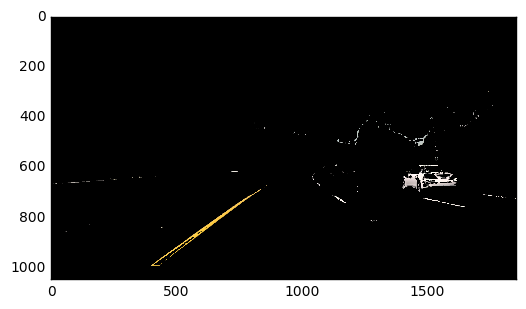

In [25]:
white_output = 'white.mp4'
clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(process_image)   # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


### ** Calculate y intercept using current points **

In [ ]:
# # Create a "color" binary image to combine with line image
# color_edges = np.dstack((edges, edges, edges)) 

# line_image = draw_line_segments(color_edges, h_lines, color=[255, 0, 0], thickness=2)
# # Draw the lines on the edge image
# lines_edges = weighted_img(color_edges, line_image)
# plt.imshow(lines_edges)